# Introduction to Computer Vision



## Used Libraries

In [4]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt

## [Camera Model](https://en.wikipedia.org/wiki/Pinhole_camera_model)

The Pin-Hole-Camera Model is a widely used camera model in computer vision. <br>

![Pin-Hole-Camera](Pictures/Pin-Hole-Camera.jpg)


>With a pin-hole camera, a 3D point **X** is projected to an image point **x** (both expressed in homogeneous coordinates) as: 

<p style="text-align: center;">λx = PX</p>

>Here, the 3x4 matrix **P** is called the *camera matrix* (*or projection matrx*). Note that the 3D point **X** has four elements in homogeneous coordinates, **X** = [X, Y, Z, W]. The scalar λ is the *inverse depth* of the 3D point and is needed if we want all coordinates to be homogeneous with the last value normalized to one.   

### The Camera Matrix

The Camera matrix can be decomposed as 

$$ P = K [R|t] $$

where R is a rotation matrix describing the orientation of the camera, **t** a 3D translation vector describing the position of the camera center, and the intrincic *calibration matrix* K describing the projection properties of the camera.  
The calibration matrix only depends on the camera properties and is in a general form written as

$$K = \begin{bmatrix}αf & s & c_{x}\\
0 & f & c_{y}\\
0 & 0 & 1
\end{bmatrix}$$

The *focal length*, f, is the distance between the image plane and the camera center. The skew, s, is only used if the pixel array of the sensor is skewed and therefore can be set to zero.     
This gives 

$$K = \begin{bmatrix}f_{x} & 0 & c_{x}\\
0 & f_{y} & c_{y}\\
0 & 0 & 1
\end{bmatrix}$$

where we used the alternatice notation f<sub>x</sub> and f<sub>y</sub>, with f<sub>x</sub> = αf<sub>y</sub>.   
The *aspect ratio*, α, is used for non-square elements. It is often safe to assume α = 1.

With this assumption, the matrix becomes

$$K = \begin{bmatrix}f & 0 & c_{x}\\
0 & f & c_{y}\\
0 & 0 & 1
\end{bmatrix}$$

Now besides the focal length, the only unknown parameters are the coordinates of the *optical center* (often also called *principle point*), the point **c** = [c<sub>x</sub>, c<sub>y</sub>]. This is usually the center of the image and image coordinates are measured from top-left corner. So these values can be approximated with half the width and height of the image. So now the only unkonw variable is the focal length f.

In [5]:
class Camera(object):
    """ Class for representing pin-hole cameras. """

    def __init__(self, P):
        """ Initialize P = K[R|t] camera model. """
        
        self.P = P
        self.K = None # calibration matrix
        self.R = None # rotation
        self.t = None # translation
        self.c = None # camera center

    def project(self, X):
        """ Project points in X (4**n array) and normalize coordinates. """

        x = np.dot(self.P, X)
        for i in range(3):
            x[i] /= x[2]

        return x

    def factor(self):
        """ Factorize the camera matrix into K,R,t as P = K[R|t] """

        # factor first 3*3 part
        K, R = linalg.rq(self.P[:,:3])

        # make diagonal of K positive
        T = np.diag(np.sign(np.diag(K)))
        if linalg.det(T) < 0:
            T[1,1] *= -1

        self.K = np.dot(K,T)
        self.R = np.dot(T,R) # T is its own inverse
        self.t = np.dot(linalg.inv(self.K), self.P[:, 3])

        return self.K, self.R, self.t

    def center(self):
        """ Compue and return the camera center """

        if self.c is not None:
            return self.c

        else:
            # compute c by factoring
            self.factor()
            self.c = -np.dot(self.R.T, self.t)
            return self.c

def rotation_matrix(a):
    """ Creates a 3D rotation matrix for rotation around the axis of the vector a """

    R = np.eye(4)
    R[:3, :3] = linalg.expm([[0, -a[2], a[1]], [a[2], 0, -a[0]], [-a[1], a[0], 0]])
    return R

    

First we need to load the data from our example. In this example we will use the "Model-House" which is one of the Oxformd multi-view datasets. Then we make the points into homogeneous coordinates and create a **Camera** object, with the projection matrix.

### Projecting 3D points

In [6]:
#import camera

# load points
points = np.loadtxt('./Examples/Model_House/house.p3d')
# matrix needs to be transposed becuase it expects the points to be like this:
# X: [[1,3,5,3,4,6,7,4,6,25,7,2,7,4,45,...],
# Y:  [6,-3,6,2,78,2,7,2,4,67,2,6,34,6,...],
# Z:  [2,5,1,545,2,345,6,2,6,2,3,4,6,2,...]
#and not like this:
#   X  Y  Z
# [[3, 6, 2],
#  [2, 6, 2],
#  [5, 2, 7],
#  [9, 0, 1],
#  ...]
# => so we need to change columns and rows
points = points.T
points = np.vstack((points, np.ones(points.shape[1])))
# np.ones(N) returns a array with size N filled with 1s

# setup camera
P = np.hstack((np.eye(3), np.array([[0],[0],[-10]])))
# np.eye(N) creates a identity matrix with dimensions NxN
cam = Camera(P)

Then the points a projected and plotted. Which looks like this:

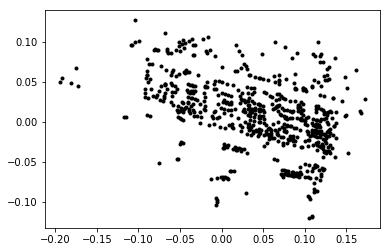

In [7]:
# project the points
x = cam.project(points)

#plot projection
plt.figure()
plt.plot(x[0], x[1], 'k.')
plt.show()

To see the change in projection while moving the camera, we will create the following example:

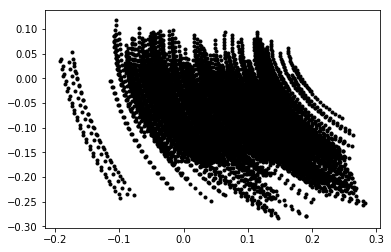

In [8]:
# create transformation
r = 0.05 * np.random.rand(3)
rot = rotation_matrix(r)

# rotate camera and project
plt.figure()
for t in range(20):
    cam.P = np.dot(cam.P, rot)
    x = cam.project(points)
    plt.plot(x[0], x[1], 'k.')

plt.show()

This image shows the project after the 3D points have been rotated around a random vector.

## Factoring the Camera Matrix

If we are given the Camera Matrix **P**, we need to be able to recover the internal parameters **K** and the position and pose **t** and **R**. This is called *factorization*. We will use to so called *RQ-factorisation*.   
This is why we need to add the function:
``` python
def factor(self):
```
to the Camera class.

### Computing the Camera Center

It is ver useful to be able to compute the camera's position in space with a given *projection matrix* **P**. The center of the camera **C** is a 3D point with the property P**C** = 0. <br>
For a camera with **P** = **K**[**R**|**t**]    
   
K[R|t]**C** = KR**C** + K**t** = 0   
   
**C** = -R<sup>T</sup> **t**


This is why we need to add the function:
``` python
def center(self):
```
to the Camera class.

## Camera Calibration
Calibrating the camera means determining the internal camera parameters, in our case the matrix **K**. If the application needs precise measurements it is possible to extend the camera modul to inculde radial distortion and other artifacts. For the most part this simple model is enough. In Computer Vision the standard way of calibrating your camera is to take lots of pictures of a flat checkerboard pattern.


### A Simple Calibration Method

- Measeure the sides of your rectangular calibration object. Let's call these d**X** and d**Y**
- Place the camera and the calibration object on a flat surface so that the camer back and calibration object are parallel and the object is roughly in the center of the camera's view. You might have to raise the camera or object to get a nice alignment
- Measure the distance from the camera to the calibration object. Let's call this d**Z**
- Take a picture and check that the setup is straight, meaning that the sides of the calibration object align with the rows and columns of the image
- Measure the width and height of the object in pixels. Let's call these dx and dy

The following relation gives the focal length

$$ f_x = \frac{dx}{dX}\,dZ  ,      f_y = \frac{dy}{dY}\,dZ$$
<br>

In my setup the object was measured to be 175 by 215 mm, d**X** = 175 and d**Y** = 215. The object was 970 mm away form the camera, so d**Z** = 970. The width and height in pixels was 595 and 720. => dx = 595, dy = 720.
Putting these calues into the above formula gives
$$ f_x = \frac{595}{175}\,970 = 3298  , f_y = \frac{720}{215}\,970 = 3248$$

In [9]:
def my_calibration(sz):
    row, col = sz
    fx = 3298*col/4032 #4032 is the camera resolution in width
    fy = 3248*row/3024 #3024 is the camera resolution in height
    K = np.diag([fx,fy,1])
    K[0,2] = 0.5*col
    K[1,2] = 0.5*row

    return K

In [10]:
def my_calibration_PCV_book(sz):
    row, col = sz
    fx = 2555*col/2592 #2592 is the camera resolution in width
    fy = 2586*row/1936 #1936 is the camera resolution in height
    K = np.diag([fx,fy,1])
    K[0,2] = 0.5*col
    K[1,2] = 0.5*row

    return K

## Pose Estimation from Planes and Markers

In [11]:
from PCV.geometry import homography
from PCV.localdescriptors import sift
import cv2

# because the sift from PCV.localdescriptors didnt work i had to use SIFT from cv2, this is why the upcoming code differs a bit form the book
# instead of sift.read_feature_from_file cv2.detectAndCompute was used
sift_CV2 = cv2.xfeatures2d.SIFT_create()

# load image
img1 = cv2.imread('./Test-Images/book_frontal.JPG')
img2 = cv2.imread('./Test-Images/book_perspective.JPG')

#img1 = cv2.imread('./Test-Images/IMG_01.JPG')
#img2 = cv2.imread('./Test-Images/IMG_02.JPG')

# find keypoints and descriptors with SIFT
kp1, des1 = sift_CV2.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
kp2, des2 = sift_CV2.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

# find point matches
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's SIFT matching ratio test
good = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good.append(m)

src_pts = np.asarray([kp1[m.queryIdx].pt for m in good])
dst_pts = np.asarray([kp2[m.trainIdx].pt for m in good])

# Constrain matches to fit homography
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 100.0)
#mask = mask.ravel()

In [12]:
def cube_points(c, wid):
    """ Creates a list of points for plotting a cube with plot. """

    p = []
    # bottonm
    p.append([c[0]-wid, c[1]-wid, c[2]-wid])
    p.append([c[0]-wid, c[1]+wid, c[2]-wid])
    p.append([c[0]+wid, c[1]+wid, c[2]-wid])
    p.append([c[0]+wid, c[1]-wid, c[2]-wid])
    p.append([c[0]-wid, c[1]-wid, c[2]-wid]) # same as first to close plot

    # top
    p.append([c[0]-wid, c[1]-wid, c[2]+wid])
    p.append([c[0]-wid, c[1]+wid, c[2]+wid])
    p.append([c[0]+wid, c[1]+wid, c[2]+wid])
    p.append([c[0]+wid, c[1]-wid, c[2]+wid])
    p.append([c[0]-wid, c[1]-wid, c[2]+wid]) # same as first to close plot

    # vertical sides
    p.append([c[0]-wid, c[1]-wid, c[2]+wid])
    p.append([c[0]-wid, c[1]+wid, c[2]+wid])
    p.append([c[0]-wid, c[1]+wid, c[2]-wid])
    p.append([c[0]+wid, c[1]+wid, c[2]-wid])
    p.append([c[0]+wid, c[1]+wid, c[2]+wid])
    p.append([c[0]+wid, c[1]-wid, c[2]+wid])
    p.append([c[0]+wid, c[1]-wid, c[2]-wid])

    return np.array(p).T

In [13]:
# camera calibration matrix 
#K = my_calibration((4032, 3024)) # camera resolution
K = my_calibration_PCV_book((747, 1000)) # camera resolution

# 3D points at plane z=0 with sides of length 0.2
box = cube_points([0,0,0.1],0.1)

#project bottom square in first image
cam1 = Camera(np.hstack((K, np.dot(K, np.array([[0],[0],[-1]])))))
# first points are the bottom square
box_cam1 = cam1.project(homography.make_homog(box[:,:5]))

# use H to transfer points to the second image
box_trans = homography.normalize(np.dot(H, box_cam1))

# conmpute second camera matrix from cam1 and H
cam2 = Camera(np.dot(H, cam1.P))
A = np.dot(linalg.inv(K), cam2.P[:,:3])
A = np.array([A[:,0], A[:,1], np.cross(A[:,0], A[:,1])]).T
cam2.P[:,:3] = np.dot(K,A)

# project with the second camera
box_cam2 = cam2.project(homography.make_homog(box))

# test: projecting point on z=0 should give the same
point = np.array([1,1,0,1]).T
print(homography.normalize(np.dot(np.dot(H, cam1.P), point)))
print(cam2.project(point))

[-1.40515953e+03 -2.12391902e+02 -1.13458885e+00]
[1.23847466e+03 1.87197241e+02 1.00000000e+00]


Visualizing the points can be done like this:

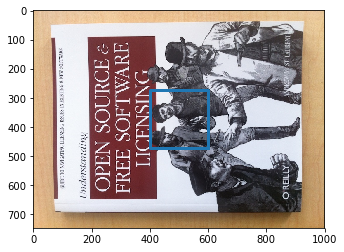

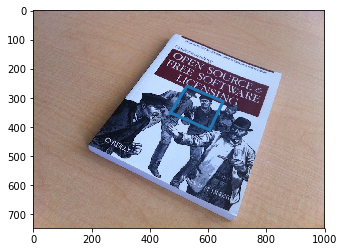

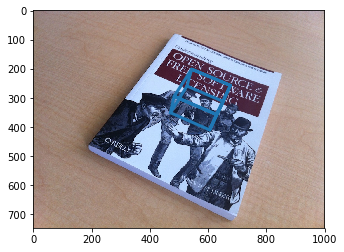

In [14]:
from PIL import Image	

im0 = np.array(Image.open('./Test-Images/book_frontal.JPG'))
im1 = np.array(Image.open('./Test-Images/book_perspective.JPG'))

#im0 = np.array(Image.open('./Test-Images/IMG_01.JPG'))
#im1 = np.array(Image.open('./Test-Images/IMG_02.JPG'))

# 2D projection of bottom square
plt.figure()
plt.imshow(im0)
plt.plot(box_cam1[0,:], box_cam1[1,:], linewidth=3)

# 2D projection of transferred with H
plt.figure()
plt.imshow(im1)
plt.plot(box_trans[0,:], box_trans[1,:], linewidth=3)

# 3D cube
plt.figure()
plt.imshow(im1)
plt.plot(box_cam2[0,:], box_cam2[1,:], linewidth=3)

plt.show()

## Svaing Camera Matrices using pickle

In [15]:
import pickle

with open('ar_camera.pkl', 'w') as f:
    pickle.dump(K,f)
    pickle.dump(np.dot(linalg.inv(K), cam2.P), f)

## Augmented Reality
*Augmented Reality* (*AR*) is a collective term for placing objects and information on top of image data. A common example is placing a 3D computer graphics model so that it looks like it belongs in the secne.

In [16]:
from OpenGL.GL import *
from OpenGL.GLU import *
import pygame, pygame.image
from pygame.locals import *

pygame 2.0.3 (SDL 2.0.16, Python 2.7.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


Pygame is a package for game development and handles display windows, input devices and much more. OpenGl is the Python binding to the OpenGL graphics programming interface.  


## From Camera Matrix to OpenGL Format

OpenGL uses a 4 x 4 matrix to represent transforms. The camera-scene transformations are seperated in two matrices, GL_PROJECTION and GL_MODELVIEW matrix. GL_PROJECTION is equivalent to the internal camera matrix **K** and handles image information. GL_MODELVIEW corresponds roughly to the **R** and *t* part of our camera matrix. The matrix contains the transformation that places the objects in front pf the camera.   
With a given camera calibration matrix **K** the following function translates the camera properties to an OpenGL projection matrix.

In [17]:
height = 747
width = 1000
import math

def set_projection_from_camera(K):
    """  Set view from a camera calibration matrix.  """

    # sets the working matrix to GL_PROJECTION, following commands will modify this matrix
    glMatrixMode(GL_PROJECTION)
    # sets the matrixto the identity matrix
    glLoadIdentity()

    # focal length x
    fx = K[0,0]
    # focal length y
    fy = K[1,1]

    #calculate the vertical field of view in degrees
    fovy = 2*np.arctan(0.5*height/fy) * 180/math.pi
    aspect = (width*fy)/(height*fx)

    # define the near and far clipping planes
    near = 0.1
    far = 100.0

    # set perspective
    gluPerspective(fovy,aspect,near,far)
    # define the whole iomage to be the view port
    glViewport(0,0,width,height)

The modelview matrix is a 4 x 4 matrix that looks like this:
$$\begin{bmatrix}R & t\\
0 & 1
\end{bmatrix}$$

where **t** is as translation vector and **R** a rotation matrix with columns equal to the direction of the three coordinate axis.   
The next functions shows how to take a 3 x 4 pin-hole camera matrix with the calibration removed(multiply **P** with **K**<sup>-1</sup> and create a model view:)

In [18]:
def set_modelview_from_camera(Rt):
    """  Set the model view matrix from camera pose.  """
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()

    # rotate teapot 90 deg around x-axis so that z-axis is up
    Rx = np.array([[1,0,0],[0,0,-1],[0,1,0]])

    # set rotation to best approximation
    R = Rt[:,:3]
    U,S,V = linalg.svd(R)
    R = np.dot(U,V)
    R[0,:] = -R[0,:] # change sign of x-axis

    # set translation
    t = Rt[:,3]

    # setup 4*4 model view matrix
    M = np.eye(4)
    M[:3,:3] = np.dot(R,Rx)
    M[:3,3] = t
    
    # transpose and flattento get column order
    M = M.T
    m = M.flatten()

    # replace model view with the new matrix
    glLoadMatrixf(m)

## Placing Virtual Objects in the Image



In [19]:
def draw_background(imname):
    """  Draw background image using a quad.  """

    # load background image (schould be .bmp) to OpenGl txture
    bg_image = pygame.image.load(imname).convert()
    bg_data = pygame.image.tostring(bg_image, "RGBX", 1)

    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    glClear(GL_COLOR_BUFFER_BIT |GL_DEPTH_BUFFER_BIT)

    # bind the texture
    glEnable(GL_TEXTURE_2D)
    glBindTexture(GL_TEXTURE_2D, glGenTextures(1))
    glTexImage2D(GL_TEXTURE_2D,0,GL_RGBA, width, height,0,GL_RGBA,GL_UNSIGNED_BYTE,bg_data)
    glTexParameterf(GL_TEXTURE_2D,GL_TEXTURE_MAG_FILTER,GL_NEAREST)
    glTexParameterf(GL_TEXTURE_2D,GL_TEXTURE_MIN_FILTER,GL_NEAREST)

    # create quad to fill the whole window
    glBegin(GL_QUADS)
    glTexCoord2f(0.0,0.0); glVertex3f(-1.0,-1.0,-1.0)
    glTexCoord2f(1.0,0.0); glVertex3f( 1.0,-1.0,-1.0)
    glTexCoord2f(1.0,1.0); glVertex3f( 1.0, 1.0,-1.0)
    glTexCoord2f(0.0,1.0); glVertex3f(-1.0, 1.0,-1.0)
    glEnd()

    #clear the texture
    glDeleteTextures(1)

In [20]:
from OpenGL.GLUT import *
#glutSolidTeapot(size)

In [21]:
def draw_teapot(size):
    """ Draw a red teapot at the origin. """
    # glEnable() function is used to turn on OpenGL features, turning the features off can be done with the function glDisable()
    glEnable(GL_LIGHTING) # enables lighting
    glEnable(GL_LIGHT0)
    glEnable(GL_DEPTH_TEST) # Depth test turned on, so objects are rendered according to their depth
    glClear(GL_DEPTH_BUFFER_BIT)

    # draw the teapot, material properties are specified.
    glMaterialfv(GL_FRONT, GL_AMBIENT, [0,0,0,0])
    glMaterialfv(GL_FRONT, GL_DIFFUSE, [0.5,0.0,0.0,0.0])
    glMaterialfv(GL_FRONT, GL_SPECULAR, [0.7,0.6,0.6,0.0])
    glMaterialf(GL_FRONT, GL_SHININESS, 0.25*128.0)
    glutSolidTeapot(size) # adds a solid Utah teapot

## Loading Models

In [22]:
def load_and_draw_model(filename):
    """ Loads a model from an .pbj file using objloader.py. Assumes there is a .mtl material file with the same name. """
    
    glEnable(GL_LIGHTING) # enables lighting
    glEnable(GL_LIGHT0)
    glEnable(GL_DEPTH_TEST) # Depth test turned on, so objects are rendered according to their depth
    glClear(GL_DEPTH_BUFFER_BIT)

    # set model color
    glMaterialfv(GL_FRONT, GL_AMBIENT, [0,0,0,0])
    glMaterialfv(GL_FRONT, GL_DIFFUSE, [0.5,0.75,1.0,0.0])
    glMaterialf(GL_FRONT, GL_SHININESS, 0.25*128.0)
    
    # load from a file
    import objloader
    obj = objloader.OBJ(filename, swapyz=True)
    glCallList(obj.gl_list)

## Trying It All Together

In [23]:
def setup():
    """ Setup window and pygame environment. """
    pygame.init()
    pygame.display.set_mode((width, height), OPENGL | DOUBLEBUF)
    pygame.display.set_caption('OpenGL AR demo')

# load camera data
with open('ar_camera.pkl','r') as f:
    K = pickle.load(f)
    Rt = pickle.load(f)

setup()
draw_background('./Test-Images/book_perspective.bmp')
set_projection_from_camera(K)
set_modelview_from_camera(Rt)
#load_and_draw_model('./Examples/Toy_Plane/toyplane.obj')
#load_and_draw_model('./Examples/LEGO_Toy_Plane/toyplane.obj')
#draw_teapot(0.02)

while True:
    event = pygame.event.poll()
    if event.type in (QUIT,KEYDOWN):
        break
    pygame.display.flip()

No handlers could be found for logger "OpenGL.arrays.numpymodule"


## Epipolar Geometry

**Epipolar Geometry** is the geometry of stereo vision. When two cameras view a 3D svene fromtwo distinct positions, there are a number of geometric relations between the 3D pionts and their projection onto the 2D images that lead to constrants between the image points. These relations are derived based on the assmption that the cameras can be approximated by the pin-hole camera model.

![Epipolar-Geometry](Pictures/epipolar-geometry.png)

## A Sample Data Set

Example Images from https://www.robots.ox.ac.uk/~vgg/data/mview/.

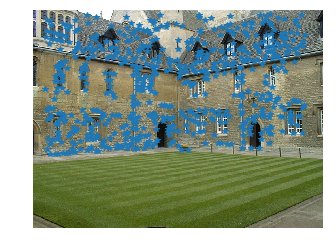

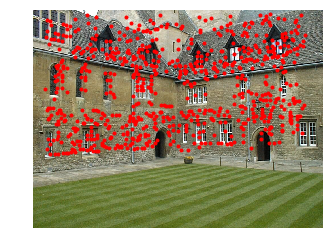

In [24]:
# load some images
im_1 = np.array(Image.open('./Examples/Merton_College_I/001.jpg'))
im_2 = np.array(Image.open('./Examples/Merton_College_I/002.jpg'))

# load 2D points for each view to a list
points2D = [np.loadtxt('./Examples/Merton_College_I/2D/00'+str(i+1)+'.corners').T for i in range(3)]

# load 3D points
points3D = np.loadtxt('./Examples/Merton_College_I/3D/p3d').T

# load correspondences
corr = np.genfromtxt('./Examples/Merton_College_I/2D/nview-corners',dtype='int')

# load camers to a list of Camera objects
P = [Camera(np.loadtxt('./Examples/Merton_College_I/2D/00'+str(i+1)+'.P')) for i in range(3)]

# make 3D points homogeneous and project
X = np.vstack( (points3D, np.ones(points3D.shape[1])))
x = P[0].project(X)

# plotting the points in view 1
plt.figure()
plt.imshow(im_1)
plt.plot(points2D[0][0], points2D[0][1],'*')
plt.axis('off')

plt.figure()
plt.imshow(im_2)
plt.plot(x[0],x[1],'r.')
plt.axis('off')

plt.show()

## Plotting 3D Date with Matplotlib

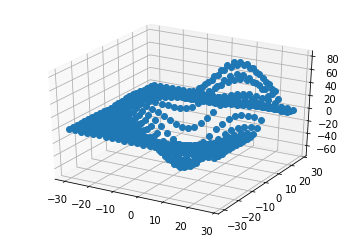

In [25]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.gca(projection="3d")

# generate 3D sample data
X, Y, Z = axes3d.get_test_data(0.25)

# plot the points in 3D
ax.plot(X.flatten(), Y.flatten(), Z.flatten(), 'o')

plt.show()

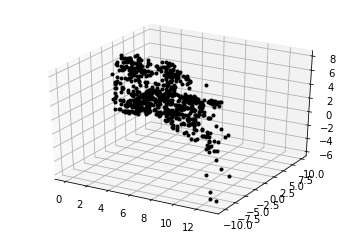

In [26]:
# plotting 3D points from example
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(points3D[0],points3D[1],points3D[2],'k.')

plt.show()

## The Epipole and Epipolar Lines

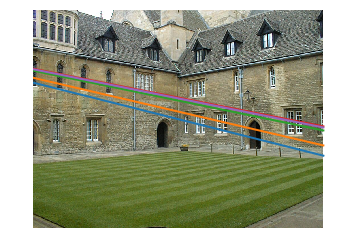

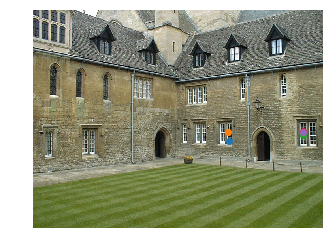

In [28]:
from PCV.geometry import sfm

# index for points in first two views
ndx = (corr[:,0]>=0) & (corr[:,1] >=0)

# get coordinates and make homogeneous
x1 = points2D[0][:,corr[ndx,0]]
x1 = np.vstack( (x1, np.ones(x1.shape[1])) )
x2 = points2D[1][:,corr[ndx,1]]
x2 = np.vstack( (x2, np.ones(x2.shape[1])) )

# compute F
F = sfm.compute_fundamental(x1,x2)

# compute the epipole
e = sfm.compute_epipole(F)

# plotting
plt.figure()
plt.imshow(im_1)

# plot each line individually, this gives nice colors
for i in range(5):
    sfm.plot_epipolar_line(im_1,F,x2[:,i],e,False)
plt.axis('off')

plt.figure()
plt.imshow(im_2)
# plot each point individually, this gives same colors as the lines
for i in range(5):
    plt.plot(x2[0,i], x2[1,i],'o')
plt.axis('off')
plt.show()

## Multiple View Reconstruction

Computing a 3D reconstruction like this is usually refferred to as *structure from motion (SfM)* since the motion of a cmera gives you 3D structure.

Assuming the camera has been calibrated, the steps are as follows:
1. Detect feature points and match them between the two images.
2. Compute the fundamental matrix from the matches.
3. Compute the camera matrices from the fundamental matrix.
4. Triangulate the 3D points.

for this the sfm.py file from Jan Erik Solem is used.

## 3D Reconstruction Example

In [ ]:
from PCV.localdescriptors import homography
from PCV.geometry import sfm
import cv2

sift_CV = cv2.xfeatures2d.SIFT_create()